>[MNIST classification](#scrollTo=j6331ZSsQGY3)

>>[Setup](#scrollTo=X35qHdh5Gzqg)

>>[Part 1 - Data Preprocessing:](#scrollTo=b08Mmbs8lr81)

>>>[1.1 Load data:](#scrollTo=pDUdGxn-ojgy)

>>>[1.2 Downscale the images samples:](#scrollTo=wNS9sVPQojhC)

>>>[1.3 Remove faulty samples from the dataset:](#scrollTo=gGeF1_qtojhK)

>>>[1.4 Preprocessing for QNN:](#scrollTo=SlJ5NVaPojhT)

>>[Part 2 - Quantum neural network (QNN):](#scrollTo=4USiqeOqGL67)

>>>[2.1 Building the models circuit:](#scrollTo=knIzawEeojho)

>>>[2.2 Wrap the model-circuit in a tfq-keras model:](#scrollTo=LY7vbY6yfABE)

>>>[2.3 Training our quantum model - QNN:](#scrollTo=lsuOzDYblA9s)

>>[Classical neural network (CNN):](#scrollTo=8952YvuWGL7J)

>>[Comparison - CNN VS QNN:](#scrollTo=RH3mam7EGL7N)

>>>[4.1 Full_QCNN VS Short_QCNN:](#scrollTo=g-_7javMJZl7)

>>>[4.2 Full_QCNN VS Fair_CNN:](#scrollTo=j-aDy4auJzy0)



# MNIST classification

This code builds a quantum neural network (QNN) to classify a simplified version of MNIST, similar to the approach used in <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al</a>. The performance of the quantum neural network on this classical data problem is compared with a classical neural network.

## Setup

Install TensorFlow & Quantum TensorFlow:

In [1]:
!pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard
    Found existing installation

In [2]:
!pip install tensorflow-quantum==0.7.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 598.8/598.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 26.7 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu121 requires sympy==1.13.1; python_version >= "3.9", but you have sympy 1.12 which is incompatible.


In [3]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<ipython-input-3-b07882b7b3a0>:2: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import importlib, pkg_resources


<module 'pkg_resources' from '/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py'>

Improting all of the necessary module dependencies:

In [4]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

## Part 1 - Data Preprocessing:

In this code we build a binary classifier to classify between the digits 3 and 6. This section dose all the necessery preprocessing:

- Loads the raw data (Keras).
- Reduce the dataset to only images of 3s and 6s.
- Downscales the images so they can fit in a quantum computer.
- Removes any faulty samples.
- Converts the binary images to Cirq circuits (preprocessing for QNN).
- Converts the Cirq circuits to TensorFlow Quantum circuits (preprocessing for QNN).

### 1.1 Load data:
Loading MNIST dataset using Keras.

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescaling images from [0,255] to [0.0,1.0] range:
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

11490434/11490434 [==============================] - 0s 0us/step
Number of original training examples: 60000
Number of original test examples: 10000


Reducing the dataset to keep only samples of 3s and 6s. At the same time converting the type of label, `y`, to bool:
* `True` for --> 3.
* `False` for --> 6.

In [6]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [7]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of reduced training examples:", len(x_train))
print("Number of reduced test examples:", len(x_test))

Number of reduced training examples: 12049
Number of reduced test examples: 1968


Debugging --> Showing the first `y = 0` sample from the reduced dataset to check if it is really a 3 or 6:

True


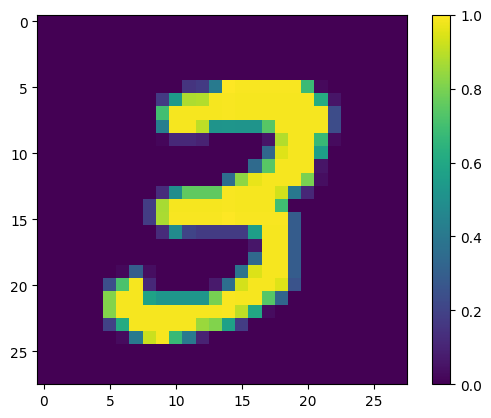

In [8]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

### 1.2 Downscale the images samples:

We doen scale the image size from `28 X 28` to a `4 X 4` as the image size of 28x28 is too big for current quantum computers:

In [9]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

Debugging --> Showing the first `y = 0` of the `4 X 4` image:

True


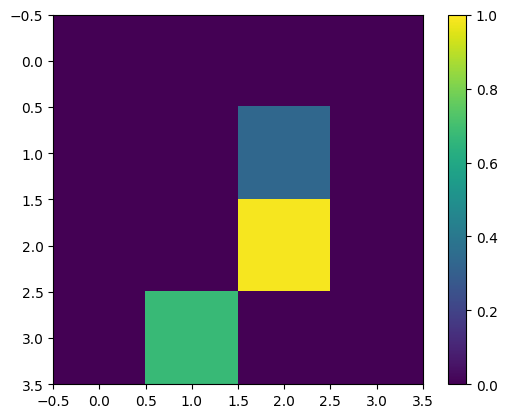

In [10]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

After our rescale we can see that the image no longer showes the handwriten diget this is due to the decrees in scale but you can see that the colors which were seen in the `28 X 28` sample are still represented here in a similar position. This means that our image downscaling was successfull.

### 1.3 Remove faulty samples from the dataset:

Here we filter the dataset to remove samples that are labeled as belonging to both classes, `3` and `6` which in our case is now `True` and `False`.

This is not a standard machine-learning procedure, but it is needed as samples should be one or the other --> A image of a handwriten diget (1 single diget) cant be both `3 & 6` which is why we used a boolian type to symbolize then as a bool type value can only be `True` or `False`.

In [11]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each sample:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)

    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Remove images that match more than one label.
          pass

    num_uniq_3 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_6 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique samples = ", len(mapping.values()))
    print("Number of samples with lable 3s = ", num_uniq_3)
    print("Number of samples with lable 6s = ", num_uniq_6)
    print("Number of samples with contradicting labels (both 3 and 6) = ", num_uniq_both, "\n")
    print("Initial number of samples = ", len(xs))
    print("Number of Non-contradicting samples = ", len(new_x))

    return np.array(new_x), np.array(new_y)

The resulting counts do not closely match the reported values in the example paper we followd as this exact procedure was not defined.

It is worth noting that applying filtering fulty samples here does not fully prevent the model from receiving fulty training examples so the next step ehre we binarizes the data will cause more collisions which we will resolve later on.

In [12]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique samples =  10387
Number of samples with lable 3s =  4912
Number of samples with lable 6s =  5426
Number of samples with contradicting labels (both 3 and 6) =  49 

Initial number of samples =  12049
Number of Non-contradicting samples =  10338


### 1.4 Preprocessing for QNN:

To process images using a quantum computer, the paper <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al</a> proposed to represent each image pixel with a qubit(quantum bit), with its state depending on the pixel value. So first step to achive that is to convert the database to a binary representation using binary encoding.

In [13]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

If we wanted to remove all of the faulty samples at this point, we would be left with only 193 samples, which are not enough samples for effective training of both NN and QNN.

The result of removing all of the faulty samples is shown in the code output below (It is only used to demonstrate the issue):

In [14]:
_ = remove_contradicting(x_train_bin, y_train_nocon)

Number of unique samples =  193
Number of samples with lable 3s =  80
Number of samples with lable 6s =  69
Number of samples with contradicting labels (both 3 and 6) =  44 

Initial number of samples =  10338
Number of Non-contradicting samples =  149


This code block checks each pixel's value in the image. If the value exceeds a threshold, the corresponding qubit, the qubit mapped to that pixel, is rotated using an $X$ gate:
* Without the $X$ gate --> The qubit remains in the `∣0⟩` state.
* With the $X$ gate: The qubit is flipped to the `∣1⟩` state.

This encodes the image's pixel information into a quantum circuit for the QNN to be able to process that data.

In [15]:
def convert_to_circuit(image):
    """Encode binary values of the classical image into a quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

In the code below we visualize the Cirq circuit created for the first sample.

This Cirq circuit visualization do not show qubits with zero gates ( `∣0⟩` ):

* `Ignore the wornings they are irrelevent`

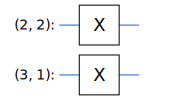

In [16]:
SVGCircuit(x_train_circ[0])

Now to compare this Cirq circuit to the indices where the sample value exceeds the threshold we use the following code:
* This allows us to check if our `convert_to_circuit(image)` function worked as intended.

In [17]:
bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T
indices

array([[2, 2],
       [3, 1]])

Now we convert these `Cirq` circuits to tensors for us to be able to use `tfq` to train and test our QNN:

In [18]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

## Part 2 - Quantum neural network (QNN):

There isnt a lot of guidance for a quantum circuit structure to classifie images. Since our classification is based on the expectation of the `readout qubit`. <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">The paper</a> propose to use two qubit gates, with the readout qubit always acted upon.

### 2.1 Building the models circuit:

In the following code we use the following layered approach:
* Each layer uses `n`, number of instances, of the same gate. With each of the data qubits acting on the readout qubit.

First we start with a simple class that will add a layer of these gates to the quantum circuit:

In [19]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout

    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

Visualizing an example quantum circuit layer to see how it looks:

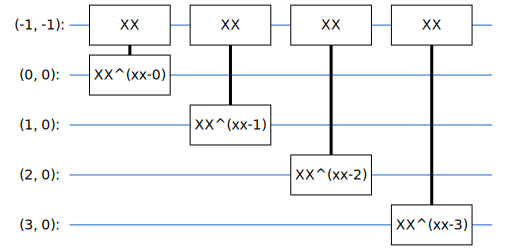

In [20]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

Now we use the following code to build a `two-layered model`, matching the circuit data size, and include the preparation of the `readout qubit` and operations:

In [45]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()

    # Prepare the readout qubit:
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))

    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Add layers:
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit with the added layers:
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [46]:
model_circuit, model_readout = create_quantum_model()

### 2.2 Wrap the model-circuit in a tfq-keras model:

In this part we build the Keras model using the quantum components. This model intake the "quantum data" , from `x_train_circ` , that encodes the classical data. We uses a `Parametrized Quantum Circuit layer` --> `tfq.layers.PQC` in order to train our model circuit on the quantum data.

To classify these images, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">the paper</a> proposed taking the expectation of the `readout qubit` in a parameterized circuit so the expectation returns a value between `1 and -1`.

In [47]:
# Build the Keras model:
model = tf.keras.Sequential([
    # The input is the data-circuit (encoded as a tf.string):
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate (range [-1,1])
    tfq.layers.PQC(model_circuit, model_readout),
])

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


For our training procedure of the model we used the `compile` method:

* Since the the expected range of our readout is `[-1,1]`, we optimizing the hinge loss to fit this range.

* A different valid approach we considerd is shifting the output range of the readout to `[0,1]`, so we could treat it as the probability our model assigns to class `3`. This could be done using the standard `tf.losses.BinaryCrossentropy` loss function from the TensorFlow library.

For us to use the hinge loss we need to make two small changes:
1. Converting the labels ( `y_train_nocon` ) from boolean to `[-1,1]`, as its the expected range for our hinge loss:

In [48]:
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

2. Using a custiom `hinge_accuracy` metric to correctly handles `[-1, 1]` as the `y_true` labels argument. This is done as `tf.losses.BinaryAccuracy(threshold=0.0)` expects the labels argument ( `y_true` ) to be a boolean:

In [58]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [59]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [60]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc_1 (PQC)                 (None, 1)                 32        
                                                                 
Total params: 32 (128.00 Byte)
Trainable params: 32 (128.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In this modle summery we can see that in total our model will have 32 parameters which can all be used for training. Also we see the layer type of our model, `Parameterized Quantum Circuit (PQC)`, this layer is a common layer used in hybrid quantum-classical models to integrate quantum computation into a classical neural networks.

### 2.3 Training our quantum model - QNN:

Now we can finally train our model — this process takes between `45 to 60 minutes`.
* If when you cheq our code you don't want to wait that long, you can use the small_train code which uses a small subset of the data. This doesn't have a segnificant affect our model's preformance during the training as it only has 32 parameters, and doesn't need a lot of data to constrain these parameters. Using this code with the fewer examples just ends the training process earlier after around `5 minutes`, but it runs long enough to show the `training progress` in the validation logs. This dosent achive the same `loss` and `hinge_accuracy` we get in our actual QNN but it is a good example for its results.

Output Values:
* `loss` - The avrage (`Avg`) loss over each epoch.
* `hinge_accuracy` - The `Avg` of hinge_accuracy of our model on the test dataset over each epoch.
* `val_loss` - The loss value we get in the end of each epoch.
* `val_hinge_accuracy` - The hinge_accuracy value we get in the end of each epoch.

Code for the short training and validation of the QNN - training on 500 examples from our training dataset:

In [61]:
EPOCHS = 3
BATCH_SIZE = 32
NUM_EXAMPLES = 500

x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

In [62]:
short_qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

short_qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
16/16 [==============================] - 86s 6s/step - loss: 0.7591 - hinge_accuracy: 0.7828 - val_loss: 0.7977 - val_hinge_accuracy: 0.7157
Epoch 2/3
16/16 [==============================] - 85s 6s/step - loss: 0.7110 - hinge_accuracy: 0.7781 - val_loss: 0.7579 - val_hinge_accuracy: 0.7162
Epoch 3/3
62/62 [==============================] - 31s 496ms/step - loss: 0.7167 - hinge_accuracy: 0.7162


Code for full training and validation of our QNN - training on all of the samples in our training dataset:
* Our training results of this model are around ` A > 85% ` accuracy(A) on the test set.

In [30]:
EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

In [31]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

In [32]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
324/324 [==============================] - 978s 3s/step - loss: 0.5449 - hinge_accuracy: 0.7890 - val_loss: 0.4675 - val_hinge_accuracy: 0.8009
Epoch 2/3
324/324 [==============================] - 970s 3s/step - loss: 0.4083 - hinge_accuracy: 0.8258 - val_loss: 0.3808 - val_hinge_accuracy: 0.8281
Epoch 3/3
62/62 [==============================] - 20s 322ms/step - loss: 0.3454 - hinge_accuracy: 0.9068


## Part 3 - Classical neural network (CNN):

While QCNN works for this simplified MNIST problem, a simple classical neural network can easily outperform a QNN on this task. After a single epoch, a classical NN can achieve `> 98% ` accuracy on the holdout set. This is due to 2 main resons:
1. The current quantoum computers are not developed enogh to compete with the constant evolution of NNs.
2. The MNIST dataset is a very well-known ML dataset so it has evolved to a point where there isnt barely any noise in the data which in our research was the main advantage of QNNs over classical NNs.

In a classical neural network for the 3-6 classification problem using the entire 28x28 image instead of subsampling the image, as it was only necessery for the quantum NN application. The indestry model easily reach nearly a accuracy of `100%` on the test set so for the sake of the comparison we will use a NN under the same data and processing constraints as our QNN. This is becuse the classical NN model has nearly 1.2M parameters which is much more then the 32 parameters our QNN has. So we decided to use a 37-parameter NN on the subsampled images in order to create a more acurate comparison:

In [33]:
def Fair_CNN_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(4,4,1)))
    model.add(tf.keras.layers.Dense(2, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model


model = Fair_CNN_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 2)                 34        
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 37 (148.00 Byte)
Trainable params: 37 (148.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
model.fit(x_train_bin,
          y_train_nocon,
          batch_size=32,
          epochs=3,
          verbose=1,
          validation_data=(x_test_bin, y_test))

fair_cnn_results = model.evaluate(x_test_bin, y_test)

Epoch 1/3
324/324 [==============================] - 2s 3ms/step - loss: 0.6478 - accuracy: 0.5388 - val_loss: 0.5428 - val_accuracy: 0.7078
Epoch 2/3
324/324 [==============================] - 1s 2ms/step - loss: 0.4103 - accuracy: 0.8178 - val_loss: 0.3282 - val_accuracy: 0.8288
Epoch 3/3
62/62 [==============================] - 0s 2ms/step - loss: 0.2643 - accuracy: 0.8277


## Part 4 - Comparison --> NN VS QNN:

### 4.1 Full_QNN VS Short_QNN:

<Axes: >

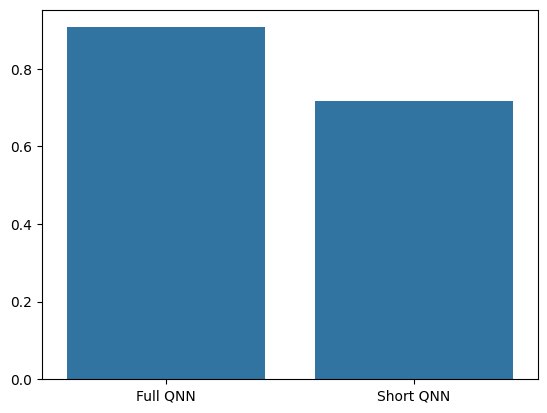

In [64]:
qnn_accuracy = qnn_results[1]
short_qnn_accuracy = short_qnn_results[1]

sns.barplot(x=["Full QNN", "Short QNN"],
            y=[qnn_accuracy, short_qnn_accuracy])

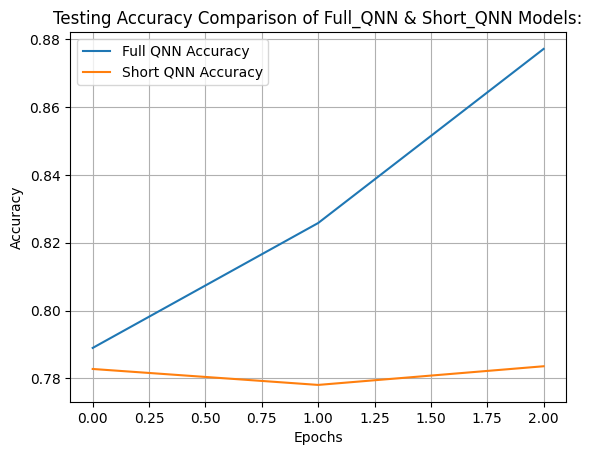

In [63]:
qnn_acuracy = [0.7890, 0.8258, 0.8771]
short_qnn_accuracy = [0.7828, 0.7781, 0.7836]


# Plot training loss for all models:
plt.plot(qnn_acuracy, label='Full QNN Accuracy')
plt.plot(short_qnn_accuracy, label='Short QNN Accuracy')

# Graph settings:
plt.title('Testing Accuracy Comparison of Full_QNN & Short_QNN Models:')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### 4.2 Full_QNN VS Fair_NN:

<Axes: >

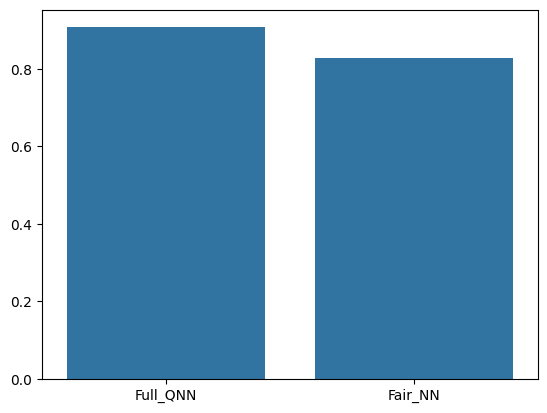

In [37]:
qnn_accuracy = qnn_results[1]
fair_cnn_accuracy = fair_cnn_results[1]

sns.barplot(x=["Full_QNN", "Fair_NN"],
            y=[qnn_accuracy, fair_cnn_accuracy])

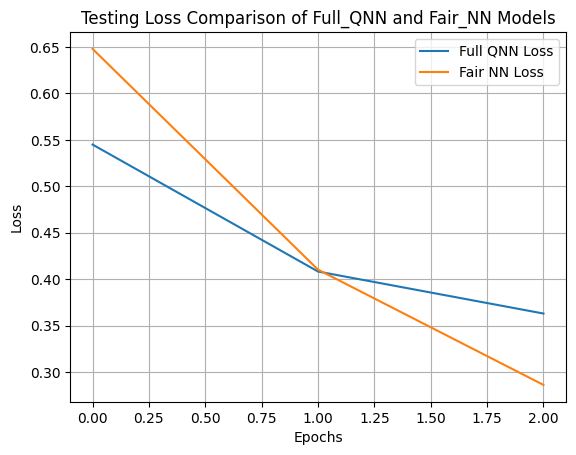

In [54]:
qnn_loss = [0.5449, 0.4083, 0.3631]
fair_cnn_loss = [0.6478, 0.4103, 0.2863]

# Plot training loss for all models
plt.plot(qnn_loss, label='Full QNN Loss')
plt.plot(fair_cnn_loss, label='Fair NN Loss')

# Graph settings
plt.title('Testing Loss Comparison of Full_QNN and Fair_NN Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

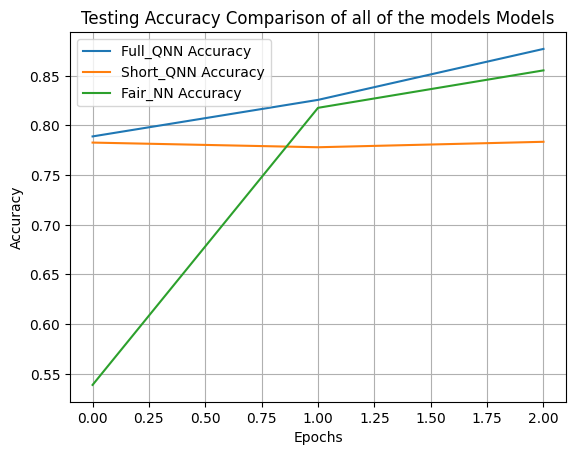

In [65]:
qnn_acuracy = [0.7890, 0.8258, 0.8771]
short_qnn_accuracy = [0.7828, 0.7781, 0.7836]
fair_cnn_acc = [0.5388, 0.8178, 0.8555]

# Plot training loss for all models
plt.plot(qnn_acuracy, label='Full_QNN Accuracy')
plt.plot(short_qnn_accuracy, label='Short_QNN Accuracy')
plt.plot(fair_cnn_acc, label='Fair_NN Accuracy')

# Graph settings
plt.title('Testing Accuracy Comparison of all of the models Models')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()